# Stack Exchange Question Classifier

Neste notebook exploraremos e resolveremos o desafio do HackerRank de [Classificação de questões do Stack Exchange](https://www.hackerrank.com/challenges/stack-exchange-question-classifier/problem). Para isso, vamos explorar algumas técnicas de processamento de linguagem natural (NLP), seja para construção de _features_ relevantes para o problema, seja na aplicação de algoritmos de classificação adequados. 

## Estrutura do dataset de treino

O dataset de treino consiste em um arquivo text que contém na primeira linha um número inteiro indicando a quantidade de linhas no restante do arquivo e as demais linhas são compostas por questões do Stack Exchange em formato JSON contendo as seguintes chaves:

1. excerpt - trecho da resposta a uma dada questão
2. question - título da questão
3. topic - tópico ao qual a questão percente

## Definição do problema

O problema a ser resolvido é a classificação de uma dada questão em um dos tópicos existentes 

In [1]:
import pandas as pd
import matplotlib
import string
import matplotlib.pyplot as plt
import json
import io

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

BASE_DATA_PATH="data/"
TRAINING_FILE_NAME="training.json"
TEST_FILE_FEATURES_NAME="input00.txt"
TEST_FILE_LABEL_NAME="output00.txt"

def read_training_dataset(f_name):
    f = open(BASE_DATA_PATH+f_name, "r")
    # descarta a primeira linha que contém apenas um número inteiro
    first_line = f.readline()
    df_aux = []
    l_number = 0
    for line in f:
        json_line = json.loads(line)
        df_aux.append(pd.DataFrame.from_records(json_line, index=[l_number]))
        l_number+=1
    df = pd.concat(df_aux)
    return(df)

def read_test_dataset(f_input_name, f_output_name):
    df = read_training_dataset(f_input_name)
#     pd.read_json(BASE_DATA_PATH+f_input_name, orient='records')
    df_label = pd.read_csv(BASE_DATA_PATH+f_output_name, header=None, names=['label'])
    df['topic'] = df_label['label']
    return(df)
    

def print_str_cells(df, col_name, n_lines, hide_special_chars=False):
    for i in range(1,n_lines+1):
        print("LINE NUMBER: {}".format(i))
        if hide_special_chars:
            print(df.loc[i, col_name])
        else:
            print(repr(df.loc[i, col_name]))
        print("================== \n")

# Explorando o dataset

A partir do código abaixo é possível perceber que tanto os textos das colunas `excerpt` e `question` possuiem caracteres especiais, tais como pontuação, acentos, caracteres não alfanuméricos. Esses caracteres podem ser importantes quando se trata de NLP. Por exemplo, emoticons como =), =/, =p, etc. podem indicar o sentimento associado a uma mensagem quando se está lidando com um problema de análise de sentimentos. Talvez a pontuação seja um fator importante caso você queira classificar um texto como "formal" ou "informal". 

Abaixo foram listados todos os tópicos existentes no dataset. Ao todo são 10 tópicos. Cada questão pertence a apenas um tópico. 

In [2]:
df = read_training_dataset(TRAINING_FILE_NAME)
df.head()

,excerpt,question,topic
0,"I'm trying to work out, in general terms, the ...",What is the effective differencial effective o...,electronics
1,Can I know which component senses heat or acts...,Heat sensor with fan cooling,electronics
2,I am replacing a wall outlet with a Cooper Wir...,Outlet Installation--more wires than my new ou...,electronics
3,"i have been reading about the buck converter, ...",Buck Converter Operation Question,electronics
4,I need help with deciding on a Master's Projec...,"Urgent help in area of ASIC design, verificati...",electronics


In [3]:
df_test = read_test_dataset(TEST_FILE_FEATURES_NAME, TEST_FILE_LABEL_NAME)
df_test.head()

,excerpt,question,topic
0,I have been working with a IS5 frequency inver...,Frequency Inverter LS IS5,electronics
1,I was taking apart this thing that I bought fr...,Why did the designer use this motor?,electronics
2,I am starting to learn to use operational ampl...,Help with amplifier with feedback,electronics
3,This may be a very basic question but as the u...,Single Supply Op Amp to Amplify 0-3.3V to 0-10V,electronics
4,I am new to all of this and I really feel over...,How to start with 3d tracking? [on hold],electronics


In [3]:
print_str_cells(df, "excerpt", 3)

LINE NUMBER: 1
u'Can I know which component senses heat or acts as heat sensor in the following circuit?\nIn the given diagram, it is said that the 4148 diode acts as the sensor. But basically it is a zener diode and ...\r\n        '

LINE NUMBER: 2
u'I am replacing a wall outlet with a Cooper Wiring USB outlet (TR7745).  The new outlet has 3 wires coming out of it--a black, a white, and a green.  Each one needs to be attached with a wire nut to ...\r\n        '

LINE NUMBER: 3
u'i have been reading about the buck converter, and have also referred to the various online resources like here.\n\n\n\nIn the above circuit, as I understand, when switch closes, current starts to increase ...\r\n        '



In [4]:
print_str_cells(df, "question", 3)

LINE NUMBER: 1
u'Heat sensor with fan cooling'

LINE NUMBER: 2
u'Outlet Installation--more wires than my new outlet can use [on hold]'

LINE NUMBER: 3
u'Buck Converter Operation Question'



In [5]:
df['topic'].unique()

array([u'electronics', u'mathematica', u'android', u'security', u'gis',
       u'photo', u'scifi', u'unix', u'apple', u'wordpress'], dtype=object)

### Analisando a distribuição de classes do dataset

Uma das preocupações que existem quando se cria um modelo de classificação é a do enviesamento do mesmo. Uma das formas de isso acontecer é ter, no dataset de treino uma quantidade muito maior de um dos valores da variável alvo em relação aos demais. Por exemplo, se, no dataset desse projeto, a quantidade de exemplos do tópico `eletronics` for muito maior do que a dos demais tópicos, o modelo tenderá a classificar a maior parte dos novos documentos como `eletronics`. 

Vale a ressalva de que nem sempre esse viés do classificador é algo ruim. No exemplo citado, se o fórum do Stack Exchange for muito focado no tópico `eletronics`, talvez o classificador só esteja refletindo uma distribuição dos dados reais, porém se isso for um problema do dataset utilizado, o classificador provavelmente errará boa parte das predições. 

A partir do gráfico abaixo, é possível perceber que a quantidade de exemplos do tópico `matematica` é bem menor do que a dos demais. Por outro lado, os tópicos `gis` e `scifi` são os que tem a maior quantidade de exemplos. Esse fato pode servir de input para realizarmos uma atividade de balanceamento de classes. 

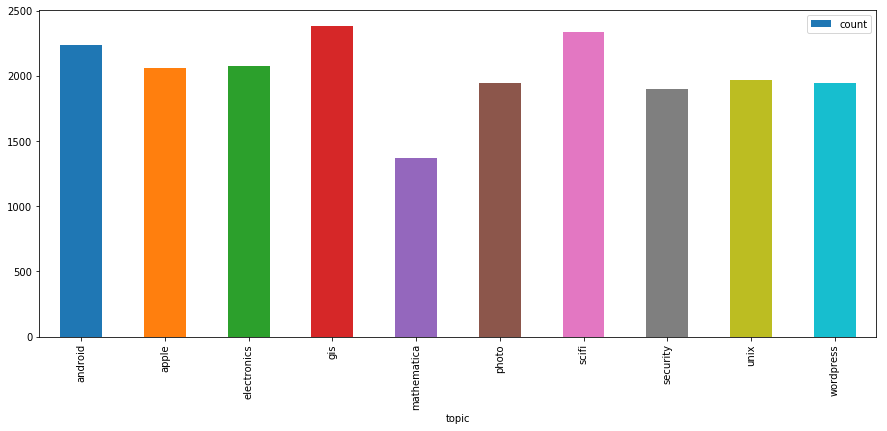

In [20]:
topis_dist = df.groupby('topic').size().reset_index()
topis_dist = topis_dist.rename(columns={0: 'count'})
topis_dist.plot(kind='bar', x="topic", y="count", figsize=(15,6))
plt.show()

### Analisando tamanho, pontuação e caracteres especiais no dataset

Além da presença de caracteres especiais e _stop words_ no texto, um outro valor que talvez influencie o desafio de classificação de texto é o tamanho dos textos em si. Olhando o dataset de um ponto de vista mais conceitual, é possível imaginar que talvez alguns tipos de questão exijam respostas de tamanhos maiores ou perguntas maiores, para melhor explicitar o problema e a solução ali presentes. Dado isso, talvez essa informação esteja relacionada com algum tópico. 

Nesta seção, vamos verificar se existe alguma ligação entre o tamanho médio dos `excerpt` e `question` e os tópicos existentes. Aproveitando o gancho, o mesmo exercício é feito para caracteres de pontuação e _stop words_. Basicamente se identificarmos uma diferença significativa nos tópicos a partir dessas métricas isso pode significar que devemos usá-las como _features_ do nosso modelo de classificação, pois elas serão capazes de diferenciar os tópicos.

Para começar, vamos montar um histograma para analisar a distribuição do tamanho dos excertos e questões. Depois faremos a análise descrita no parágrafo anterior.

In [3]:
df["excerpt_len"] = df["excerpt"].apply(lambda x: len(x))
df["question_len"] = df["question"].apply(lambda x: len(x))

count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

df["excerpt_punctuation_len"] = df["excerpt"].apply(lambda x: count(x, string.punctuation))
df["question_punctuation_len"] = df["question"].apply(lambda x: count(x, string.punctuation))
df["excerpt_stopw_len"] = df["excerpt"].apply(lambda x: count(x, string.punctuation))
df["question_stopw_len"] = df["question"].apply(lambda x: count(x, string.punctuation))
df["excerpt_punctuation_ratio"] = df["excerpt_punctuation_len"]/df["excerpt_len"]
df["question_punctuation_ratio"] = df["question_punctuation_len"]/df["question_len"]
df["excerpt_stopw_ratio"] = df["excerpt_stopw_len"]/df["excerpt_len"]
df["question_stopw_ratio"] = df["question_stopw_len"]/df["question_len"]

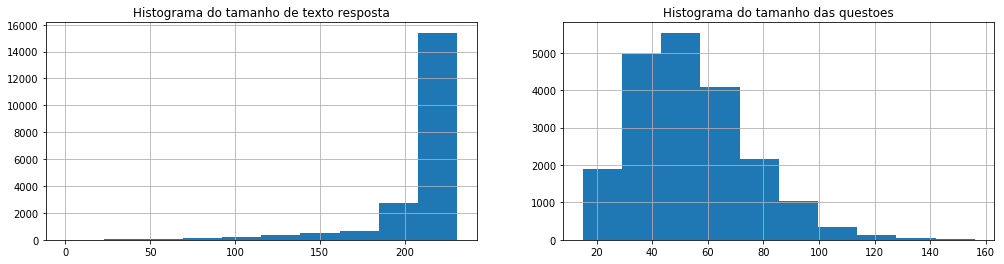

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,4))

axes[0].set_title("Histograma do tamanho de texto resposta")
df["excerpt_len"].hist(ax=axes[0], bins=10)
axes[1].set_title("Histograma do tamanho das questoes")
df["question_len"].hist(ax=axes[1])

plt.show()

In [4]:
df_grouped = df.groupby("topic").agg({'excerpt_len': 'mean', 'question_len': 'mean', 
                        'excerpt_punctuation_ratio': 'mean', 'question_punctuation_ratio': 'mean',
                        'excerpt_stopw_ratio': 'mean', 'question_stopw_ratio': 'mean'}).reset_index()

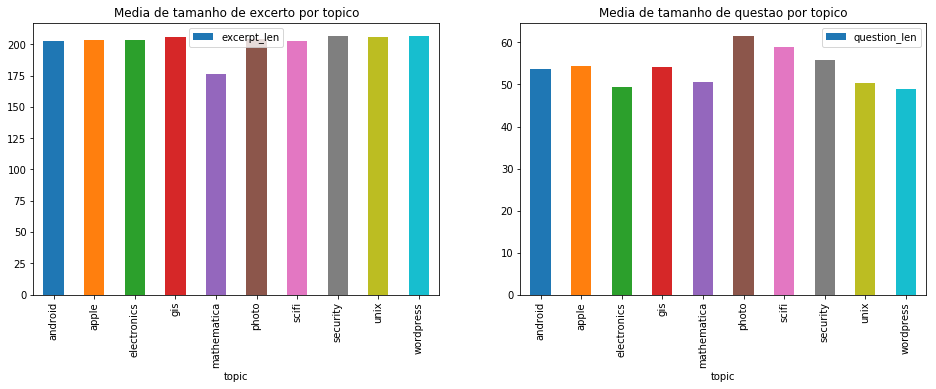

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,10))
axes[0,0].set_title("Media de tamanho de excerto por topico")
df_grouped.plot.bar(x="topic", y="excerpt_len", ax=axes[0,0], sharex=axes[2,0])
axes[0,1].set_title("Media de tamanho de questao por topico")
df_grouped.plot.bar(x="topic", y="question_len", ax=axes[0,1], sharex=axes[2,1])
axes[1,0].set_title("Media da razao de caracteres de pontuacao e excerto por topico")
df_grouped.plot.bar(x="topic", y="excerpt_punctuation_ratio", ax=axes[1,0], sharex=axes[2,0])
axes[1,1].set_title("Media da razao de caracteres de pontuacao e questao por topico")
df_grouped.plot.bar(x="topic", y="question_punctuation_ratio", ax=axes[1,1], sharex=axes[2,0])
axes[2,0].set_title("Media da razao de stopwords e excerto por topico")
df_grouped.plot.bar(x="topic", y="excerpt_stopw_ratio", ax=axes[2,0])
axes[2,1].set_title("Media da razao de stopwords e questao por topico")
df_grouped.plot.bar(x="topic", y="question_stopw_ratio", ax=axes[2,1])
plt.show()

A partir dos gráficos acima, podemos perceber que:

1. Os excertos tem um tamanho está concentrado ao redor de 200 caracteres. A distribuição de tamanho de caracteres nos excertos é bem enviesada
2. As questões tem uma distribuição um pouco mais parecida com uma distribuição normal, mas com uma cauda alongada para o lado direito. Mas podemos dizer que a maioria das questões tem um tamanho concentrado entre 20 e 80 caracteres
3. As métricas citadas no início dessa seção não tem uma grande variação entre os diversos tópicos (vide gráficos coloridos acima)

Dado isso, talvez usar o tamanho (em caracteres) dos documentos e _stop words_ como _features_ do modelo não seja algo relevante. Isso corrobora com o conhecimento prévio adquirido nas leituras da seção **Referências**. 

## Feature Engineering

Nesta seção, para a construção das _features_ do modelo consideraremos algumas premissas:

1. **As _stop words_ não tem impacto para o resultado do modelo**
2. **Letras maiúsculas ou minúsculas não fazem diferença para o resultado do modelo**: essa premissa foi definida a partir da leitura de algumas entradas do dataset de treino. Tanto nas questões quanto nos excertos temos a presença de siglas com letras maiúsculas (representando objetos, voltagem, marca de produto, etc.), iniciais de frases com letra maiúscula e etc., mas nos casos observados a caixa do texto não parece influenciar na definição do tópico
3. **Pontuação pode ser desconsiderada mesmo que ela faça parte de palavras**: o caso especial a ser considerado aqui como ponto negativo é que algumas palavras são compostas, portanto, separadas por hífen. Com essa premissa perderemos a visibilidade sobre esses casos. 
4. **As colunas `excerpt` e `question` podem ser consideradas um texto só para termos de classificação**: esta premissa vem da noção intuitiva de que tanto a questão quanto o excerto dela podem conter dicas sobre o tópico sobre o qual ela está falando. O exemplo abaixo ilustra esse raciocínio. 

```json
{"topic":"electronics","question":"Aluminum Electrolytic Capacitor Dissipation Factor","excerpt":"I am using a big aluminum electrolytic capacitor (400V/470uF/105°C) after a 220VAC bridge rectifier in a motor application.\n\nDuring the burn-in test (180VDC, 6A seen by the motor) with a constant ...\r\n        "}
```

Em um desafio de NLP as features que irão para o modelo são basicamente as palavras (também chamadas de _tokens_) ou os n-gramas que compõem os textos, mas temos formas diferentes de metrificar a presença dessas palavras nos textos. 

1. WordCount
2. Frequência de termos - TF
3. TF-IDF

Vamos gerar neste notebook as 3 primeiras formas de _features_. Além disso é preciso unir o conteúdo das colunas `excerpt` e `question` e transformar todas as letras para caixa baixa. É possível representar visualmente as três formas de _features_ citadas como uma tabela, na qual cada linha representa uma sentença/frase e cada coluna uma palavra existente no dataset e o que varia aqui é a métrica utilizada para contabilizar as palavras. As tabelas abaixo ilustram isso. Usaremos as duas frases abaixo extraídas do dataset como exemplo:

* Frase 01: "Heat sensor with fan cooling"
* Frase 02: "Buck Converter Operation Question"

Tabela 1: representação visual de WordCount - cada célula representa quantas vezes cada palavra aparece nas sentenças

|    	| heat 	| sensor 	| with 	| fan 	| cooling 	| buck 	| converter 	| operation 	| question 	|
|----	|------	|--------	|------	|-----	|---------	|------	|-----------	|-----------	|----------	|
| Frase 01 	| 1    	| 1      	| 1    	| 1   	| 1       	| 0    	| 0         	| 0         	| 0        	|
| Frase 02  	| 0    	| 0      	| 0    	| 0   	| 0       	| 1    	| 1         	| 1         	| 1        	|

Tabela 2: representação visual de Frequência de termos - cada célula representa a frequência de cada palavra nas sentenças ( $\frac{N_{palavra}}{ N_{palavras}}$ )

|          	| heat 	| sensor 	| with 	| fan 	| cooling 	| buck 	| converter 	| operation 	| question 	|
|----------	|------	|--------	|------	|-----	|---------	|------	|-----------	|-----------	|----------	|
| Frase 01 	| 0.2  	| 0.2    	| 0.2  	| 0.2 	| 0.2     	| 0    	| 0         	| 0         	| 0        	|
| Frase 02 	| 0    	| 0      	| 0    	| 0   	| 0       	| 0.25 	| 0.25      	| 0.25      	| 0.25     	|

### Pré processamento

In [26]:
full_text_col = 'full_text'
required_columns = ["excerpt", "question", "topic", full_text_col]
df[full_text_col] = df["question"] + " " + df["excerpt"]
df[full_text_col] = df[full_text_col].str.lower()

le = LabelEncoder()

X = df[full_text_col]
# y = df['topic']
y = le.fit_transform(df['topic'])

df_test[full_text_col] = df_test["question"] + " " + df_test["excerpt"]
df_test[full_text_col] = df_test[full_text_col].str.lower()
X_final_test = df_test[full_text_col]
y_final_test = le.fit_transform(df_test['topic'])

### WordCount

#### Unigram

In [27]:
count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(X)

#### Bigram

In [28]:
count_vec_ngram = CountVectorizer(ngram_range=(2, 2))
X_counts_bigram = count_vec_ngram.fit_transform(X)

### Frequência de termos - TF

In [29]:
tf = TfidfTransformer(use_idf=False, norm="l1")
X_freq = tf.fit_transform(X_counts)

### TF-IDF

In [30]:
tf = TfidfTransformer(norm="l1")
X_tfidf = tf.fit_transform(X_counts)

## Aplicação de algoritmos

Nesta seção alguns algoritmos serão aplicados para gerar a classificação de cada um dos tópicos. Dois algoritmos comumente utilizados nesse contexto são: Naive Bayes e Support Vector Machines (SVM).  

Mas antes, é preciso dividir o dataset entre treino e teste. Faremos isso na proporção 80% para treino e 20% para testes.

In [31]:
X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(X_counts, y, test_size=.2)
X_train_bigram, X_test_bigram, y_train_bigram, y_test_bigram = train_test_split(X_counts_bigram, y, test_size=.2)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y, test_size=.2)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=.2)

### Multinomial Naive Bayes

In [32]:
clf_counts = MultinomialNB().fit(X_train_counts, y_train_counts)
clf_bigram = MultinomialNB().fit(X_train_bigram, y_train_bigram)
clf_freq = MultinomialNB().fit(X_train_freq, y_train_freq)
clf_tfidf = MultinomialNB().fit(X_train_tfidf, y_train_tfidf)

In [33]:
y_pred_counts = clf_counts.predict(X_test_counts)
y_pred_bigram = clf_bigram.predict(X_test_bigram)
y_pred_freq = clf_freq.predict(X_test_freq)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

### Support Vector Machines

Como SVM é um modelo paramétrico e não conseguimos aprender os hiper parâmetros através do processo de aprendizagem, nos resta fazer diferentes testes com esses hiperparâmetros. Para isso, usaremos a técnica de GridSearch. Como 

1. GridSearch
2. Cross Validation

In [34]:
param_grid = [
  {'C': [1, 10, 100, 1000]}
 ]
svc = LinearSVC()
clf_counts = GridSearchCV(svc, param_grid).fit(X_train_counts, y_train_counts)
clf_bigram = GridSearchCV(svc, param_grid).fit(X_train_bigram, y_train_bigram)
clf_freq = GridSearchCV(svc, param_grid).fit(X_train_freq, y_train_freq)
clf_tfidf = GridSearchCV(svc, param_grid).fit(X_train_tfidf, y_train_tfidf)

In [35]:
svm_y_pred_counts = clf_counts.predict(X_test_counts)
svm_y_pred_bigram = clf_bigram.predict(X_test_bigram)
svm_y_pred_freq = clf_freq.predict(X_test_freq)
svm_y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

## Avaliação dos modelos

Para cada um dos modelos, averiguaremos a acurácia dos mesmos uma vez que é uma métrica semelhante aquela utilizada no desafio do Hacker Rank. 

In [36]:
acc_counts = accuracy_score(y_test_counts, y_pred_counts)
acc_bigram = accuracy_score(y_test_bigram, y_pred_bigram)
acc_freq = accuracy_score(y_test_freq, y_pred_freq)
acc_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)

print("Metricas usando MNB")
print("Acuracia de counts = {}".format(acc_counts))
print("Acuracia de bigram = {}".format(acc_bigram))
print("Acuracia de freq = {}".format(acc_freq))
print("Acuracia de tfidf = {}".format(acc_tfidf))
print("-----------------------------------------------------")


svm_acc_counts = accuracy_score(y_test_counts, svm_y_pred_counts)
svm_acc_bigram = accuracy_score(y_test_bigram, svm_y_pred_bigram)
svm_acc_freq = accuracy_score(y_test_freq, svm_y_pred_freq)
svm_acc_tfidf = accuracy_score(y_test_tfidf, svm_y_pred_tfidf)

print("Metricas usando SVM")
print("Acuracia de counts = {}".format(svm_acc_counts))
print("Acuracia de bigram = {}".format(svm_acc_bigram))
print("Acuracia de freq = {}".format(svm_acc_freq))
print("Acuracia de tfidf = {}".format(svm_acc_tfidf))
print("-----------------------------------------------------")

Metricas usando MNB
Acuracia de counts = 0.888724035608
Acuracia de bigram = 0.819485657765
Acuracia de freq = 0.469337289812
Acuracia de tfidf = 0.604846686449
-----------------------------------------------------
Metricas usando SVM
Acuracia de counts = 0.884025717112
Acuracia de bigram = 0.812809099901
Acuracia de freq = 0.900346191889
Acuracia de tfidf = 0.915430267062
-----------------------------------------------------


A tabela abaixo apresenta a acurácia dos modelos usando features sem a aplicação de steemer nas palavras.

<table>
  <tr>
    <th>Algoritmo / Feature</th>
    <th>WordCount (unigram)</th>
    <th>WordCount (bigram)</th>
    <th>Term Frequency</th>
    <th>TF-IDF</th>
  </tr>
  <tr>
    <td>Multinomial Naive Bayes</td>
    <td>0.90</td>
    <td>0.82</td>
    <td>0.50</td>
    <td>0.61</td>
  </tr>
  <tr>
    <td>Support Vector Machines</td>
    <td>0.89</td>
    <td>0.81</td>
    <td>0.91</td>
    <td>0.92</td>
  </tr>
</table>

A partir da tabela acima, o classificador com melhor resultado será utilizado para classificar os resultados do dataset de testes. Os resultados são apresentados abaixo.

In [17]:
X_final_test_counts = count_vec.transform(X_final_test)

In [18]:
# tf = TfidfTransformer()
X_final_test_tfidf = tf.transform(X_final_test_counts)
svm_y_pred = clf_tfidf.predict(X_final_test_tfidf)

acc = accuracy_score(y_final_test, svm_y_pred)

print("Acuracia do melhor classificador (SVM com Unigramas e TF-IDF) = {}".format(acc))

Acuracia do melhor classificador (SVM com Unigramas e TF-IDF) = 0.920369877594


Vemos, portanto, que a acurácia do modelo na base de testes é semelhante ao que obtivemos na fase de treino e seleção do algoritmo, 92%. 

## Outras abordagens possíveis

AS seções anteriores explicaram os principais conceitos utilizados nesse projeto para resolver o problema de classificação de texto. Também optou-se por uma das várias abordagens possíveis. Nesta seção apresentaremos variações de técnicas que podem melhorar o resultado do modelo criado. São elas: 

1. Combinação de bigramas com frequência de termos e TF-IDF
2. Cross validation na criação dos classificadores
3. Uso de stemmer para reduzir as palavras ao seu radical principal e diminuir o espaço amostral de _features_ do modelo
4. Balanceamento de classes

### Bigramas com outras métricas

#### Frequência de termos

In [40]:
tf = TfidfTransformer(use_idf=False, norm="l1")
X_freq = tf.fit_transform(X_counts_bigram)

#### TF-IDF

In [41]:
tf_idf = TfidfTransformer(norm="l1")
X_tfidf = tf_idf.fit_transform(X_counts_bigram)

#### Aplicação do modelo e avaliação do mesmo

In [42]:
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y, test_size=.2)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=.2)

# MULTINOMIAL NAIVE BAYES
clf_freq = MultinomialNB().fit(X_train_freq, y_train_freq)
clf_tfidf = MultinomialNB().fit(X_train_tfidf, y_train_tfidf)

y_pred_freq = clf_freq.predict(X_test_freq)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)


# LINEAR SUPPORT VECTOR MACHINES
param_grid = [
  {'C': [1, 10, 100, 1000]}
 ]
svc = LinearSVC()
clf_freq = GridSearchCV(svc, param_grid).fit(X_train_freq, y_train_freq)
clf_tfidf = GridSearchCV(svc, param_grid).fit(X_train_tfidf, y_train_tfidf)

svm_y_pred_freq = clf_freq.predict(X_test_freq)
svm_y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

acc_freq = accuracy_score(y_test_freq, y_pred_freq)
acc_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)

print("Metricas usando MNB")
print("Acuracia de freq = {}".format(acc_freq))
print("Acuracia de tfidf = {}".format(acc_tfidf))
print("-----------------------------------------------------")

svm_acc_freq = accuracy_score(y_test_freq, svm_y_pred_freq)
svm_acc_tfidf = accuracy_score(y_test_tfidf, svm_y_pred_tfidf)

print("Metricas usando SVM")
print("Acuracia de freq = {}".format(svm_acc_freq))
print("Acuracia de tfidf = {}".format(svm_acc_tfidf))
print("-----------------------------------------------------")

Metricas usando MNB
Acuracia de freq = 0.297725024728
Acuracia de tfidf = 0.305390702275
-----------------------------------------------------
Metricas usando SVM
Acuracia de freq = 0.811819980218
Acuracia de tfidf = 0.825914935707
-----------------------------------------------------


<table>
  <tr>
    <th>Algoritmo / Feature</th>
    <th>Term Frequency</th>
    <th>TF-IDF</th>
  </tr>
  <tr>
    <td>Multinomial Naive Bayes</td>
    <td>0.29</td>
    <td>0.24</td>
  </tr>
  <tr>
    <td>Support Vector Machines</td>
    <td>0.80</td>
    <td>0.82</td>
  </tr>
</table>


A partir da tabela acima, é possível concluir que o uso de bigramas para esse desafio não melhora a acurácia do modelo. O classificador com melhor resultado será utilizado para classificar os resultados do dataset de testes. Os resultados são apresentados abaixo.

In [43]:
X_final_test_counts = count_vec_ngram.transform(X_final_test)

In [45]:
X_final_test_tfidf = tf_idf.transform(X_final_test_counts)
svm_y_pred = clf_tfidf.predict(X_final_test_tfidf)

acc = accuracy_score(y_final_test, svm_y_pred)

print("Acuracia do melhor classificador (SVM com Unigramas e TF-IDF) = {}".format(acc))

Acuracia do melhor classificador (SVM com Unigramas e TF-IDF) = 0.829563597658


### Aplicando cross validation

#### Feature engineering

Usaremos nessa seção apenas unigramas. Não serão feitos testes com bigramas. É possível encontrar uma explicação detalhada sobre cross validation neste [link](https://www.youtube.com/watch?v=6dbrR-WymjI)

In [17]:
def apply_cross_validation(n_folds, X, y, model):
    best_score = -1000
    best_model = None
    kf = KFold(n_splits=n_folds)
    for train_index, test_index in kf.split(X):
#         print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = model.fit(X_train, y_train)
        y_pred = clf_counts.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_model = clf
    print("Melhor acuracia = {}".format(best_score))
    return(best_model)
        

# WORD COUNT
count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(X)

# TERM FREQUENCY
tf = TfidfTransformer(use_idf=False)
X_freq = tf.fit_transform(X_counts)

# TF-IDF
tf_idf = TfidfTransformer()
X_tfidf = tf_idf.fit_transform(X_counts)

# SPLIT DO DATASET
X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(X_counts, y, test_size=.2)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y, test_size=.2)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=.2)

# TREINO DO MODELO MULTONOMIAL NAIVE BAYES
mnb = MultinomialNB()
clf_counts = apply_cross_validation(10, X_train_counts, y_train_counts, mnb)
clf_freq = apply_cross_validation(10, X_train_freq, y_train_freq, mnb)
clf_tfidf = apply_cross_validation(10, X_train_tfidf, y_train_tfidf, mnb)

# TESTE E VALIDACAO DO MODELO MULTONOMIAL NAIVE BAYES
y_pred_counts = clf_counts.predict(X_test_counts)
y_pred_freq = clf_freq.predict(X_test_freq)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

# TREINO DO MODELO LINEAR SUPPORT VECTOR MACHINES
param_grid = [
  {'C': [1, 10, 100, 1000]}
 ]
svc = LinearSVC()
clf_counts = GridSearchCV(svc, param_grid, cv=10).fit(X_train_counts, y_train_counts)
clf_freq = GridSearchCV(svc, param_grid, cv=10).fit(X_train_freq, y_train_freq)
clf_tfidf = GridSearchCV(svc, param_grid, cv=10).fit(X_train_tfidf, y_train_tfidf)

# TESTE E VALIDACAO DO MODELO LINEAR SUPPORT VECTOR MACHINES
svm_y_pred_counts = clf_counts.predict(X_test_counts)
svm_y_pred_freq = clf_freq.predict(X_test_freq)
svm_y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

acc_counts = accuracy_score(y_test_counts, y_pred_counts)
acc_freq = accuracy_score(y_test_freq, y_pred_freq)
acc_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)

print("Metricas usando MNB")
print("Acuracia de counts = {}".format(acc_counts))
print("Acuracia de freq = {}".format(acc_freq))
print("Acuracia de tfidf = {}".format(acc_tfidf))
print("-----------------------------------------------------")


svm_acc_counts = accuracy_score(y_test_counts, svm_y_pred_counts)
svm_acc_freq = accuracy_score(y_test_freq, svm_y_pred_freq)
svm_acc_tfidf = accuracy_score(y_test_tfidf, svm_y_pred_tfidf)

print("Metricas usando SVM")
print("Acuracia de counts = {}".format(svm_acc_counts))
print("Acuracia de freq = {}".format(svm_acc_freq))
print("Acuracia de tfidf = {}".format(svm_acc_tfidf))
print("-----------------------------------------------------")

Melhor acuracia = 0.985776128633
Melhor acuracia = 0.828182941904
Melhor acuracia = 0.87012987013
Metricas usando MNB
Acuracia de counts = 0.869683481701
Acuracia de freq = 0.840751730959
Acuracia de tfidf = 0.860039564787
-----------------------------------------------------
Metricas usando SVM
Acuracia de counts = 0.888476755687
Acuracia de freq = 0.907022749753
Acuracia de tfidf = 0.916913946588
-----------------------------------------------------


<table>
  <tr>
    <th>Algoritmo / Feature</th>
    <th>WordCount</th>
    <th>Term Frequency</th>
    <th>TF-IDF</th>
  </tr>
  <tr>
    <td>Multinomial Naive Bayes</td>
    <td>0.87</td>
    <td>0.85</td>
    <td>0.86</td>
  </tr>
  <tr>
    <td>Support Vector Machines</td>
    <td>0.89</td>
    <td>0.91</td>
    <td>0.92</td>
  </tr>
</table>


A partir da tabela acima, é possível concluir usar Cross Validation com SVM gerou o score mais alto de acurácia, 0.92. Esse crescimento não foi significativo em relação aos apresentados anteriormente, numa situação de mundo real, não tenho certeza se esse caminho seria válido de ser seguido.

### Aplicando um stemmer

Quando trabalhamos em tasks de NLP, lidamos com palavras que estão conjugadas em diferentes tempos verbais, graus (ex: advérbios no superlativo), gênero e número, mas que essencialmente continuam representando o mesmo conceito. Se observarmos os trabalhos feitos anteriormente nesse projeto, nossas _features_ não levam em consideração esse fator, o que pode acarretar na existência de _features_ que representam o mesmo conceito desnecessariamente. Para lidar com isso, precisamos normalizar as palavras. Em NLP, as duas principais formas de lidar com isso são:

1. Stemming: processo de redução das palavras a sua base (`stem`). Em alguns lugares vocề encontrará que é o processo de remoção das flexões/derivações das palavras, mantendo apenas o seu radical (morfema básico que guarda o significado da mesma)
2. Lemmatization: processo que deflexiona uma palavra a fim de obter o seu lema (forma canônica), que é a representação singular masculino para substantivos e adjetivos e infinitivo para verbos.

O stemmer mais famoso é o de Porter, mas não entraremos em detalhes sobre o funcionamento do mesmo, apenas o aplicaremos no nosso projeto a fim de obter melhores resultados. 


In [19]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

#### WordCount (Unigram)

In [20]:
stem_count_vec = CountVectorizer(analyzer=stemmed_words)
X_counts = stem_count_vec.fit_transform(X)

#### WordCount (Bigram)

In [21]:
count_vec_ngram = CountVectorizer(ngram_range=(2, 2), analyzer=stemmed_words)
X_counts_bigram = count_vec_ngram.fit_transform(X)

#### TF

In [22]:
tf = TfidfTransformer(use_idf=False, norm="l1")
X_freq = tf.fit_transform(X_counts)

#### TF-IDF

In [23]:
tf_idf = TfidfTransformer(norm="l1")
X_tfidf = tf_idf.fit_transform(X_counts)

#### Aplicação de algoritmos e resultados

In [25]:
# TRAIN TEST SPLIT
X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(X_counts, y, test_size=.2)
X_train_bigram, X_test_bigram, y_train_bigram, y_test_bigram = train_test_split(X_counts_bigram, y, test_size=.2)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y, test_size=.2)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=.2)

# MULTINOMIAL NAIVE BAYES
clf_counts = MultinomialNB().fit(X_train_counts, y_train_counts)
clf_bigram = MultinomialNB().fit(X_train_bigram, y_train_bigram)
clf_freq = MultinomialNB().fit(X_train_freq, y_train_freq)
clf_tfidf = MultinomialNB().fit(X_train_tfidf, y_train_tfidf)

y_mnb_pred_counts = clf_counts.predict(X_test_counts)
y_mnb_pred_bigram = clf_bigram.predict(X_test_bigram)
y_mnb_pred_freq = clf_freq.predict(X_test_freq)
y_mnb_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

# LINEAR SVM
param_grid = [
  {'C': [1, 10, 100, 1000]}
 ]
svc = LinearSVC()
clf_svm_counts = GridSearchCV(svc, param_grid).fit(X_train_counts, y_train_counts)
clf_svm_bigram = GridSearchCV(svc, param_grid).fit(X_train_bigram, y_train_bigram)
clf_svm_freq = GridSearchCV(svc, param_grid).fit(X_train_freq, y_train_freq)
clf_svm_tfidf = GridSearchCV(svc, param_grid).fit(X_train_tfidf, y_train_tfidf)

y_svm_pred_counts = clf_svm_counts.predict(X_test_counts)
y_svm_pred_bigram = clf_svm_bigram.predict(X_test_bigram)
y_svm_pred_freq = clf_svm_freq.predict(X_test_freq)
y_svm_pred_tfidf = clf_svm_tfidf.predict(X_test_tfidf)

acc_counts = accuracy_score(y_test_counts, y_mnb_pred_counts)
acc_bigram = accuracy_score(y_test_counts, y_mnb_pred_bigram)
acc_freq = accuracy_score(y_test_freq, y_mnb_pred_freq)
acc_tfidf = accuracy_score(y_test_tfidf, y_mnb_pred_tfidf)

print("Metricas usando MNB")
print("Acuracia de counts = {}".format(acc_counts))
print("Acuracia de bigram = {}".format(acc_bigram))
print("Acuracia de freq = {}".format(acc_freq))
print("Acuracia de tfidf = {}".format(acc_tfidf))
print("-----------------------------------------------------")


svm_acc_counts = accuracy_score(y_test_counts, y_svm_pred_counts)
svm_acc_bigram = accuracy_score(y_test_counts, y_svm_pred_bigram)
svm_acc_freq = accuracy_score(y_test_freq, y_svm_pred_freq)
svm_acc_tfidf = accuracy_score(y_test_tfidf, y_svm_pred_tfidf)

print("Metricas usando SVM")
print("Acuracia de counts = {}".format(svm_acc_counts))
print("Acuracia de bigram = {}".format(svm_acc_bigram))
print("Acuracia de freq = {}".format(svm_acc_freq))
print("Acuracia de tfidf = {}".format(svm_acc_tfidf))
print("-----------------------------------------------------")

Metricas usando MNB
Acuracia de counts = 0.895647873393
Acuracia de bigram = 0.103857566766
Acuracia de freq = 0.566518298714
Acuracia de tfidf = 0.659742828882
-----------------------------------------------------
Metricas usando SVM
Acuracia de counts = 0.885014836795
Acuracia de bigram = 0.10237388724
Acuracia de freq = 0.901582591494
Acuracia de tfidf = 0.915430267062
-----------------------------------------------------


<table>
  <tr>
    <th>Algoritmo / Feature</th>
    <th>Word count</th>
    <th>Term Frequency</th>
    <th>TF-IDF</th>
  </tr>
  <tr>
    <td>Multinomial Naive Bayes</td>
    <td>0.90</td>
    <td>0.52</td>
    <td>0.63</td>
  </tr>
  <tr>
    <td>Support Vector Machines</td>
    <td>0.89</td>
    <td>0.91</td>
    <td>0.92</td>
  </tr>
</table>

A partir da tabela acima, o classificador com melhor resultado será utilizado para classificar os resultados do dataset de testes. Os resultados são apresentados abaixo.

In [37]:
X_final_test_counts = stem_count_vec.transform(X_final_test)

In [44]:
X_final_test_tfidf = tf_idf.transform(X_final_test_counts)
svm_y_pred = clf_svm_tfidf.predict(X_final_test_tfidf)

acc = accuracy_score(y_final_test, svm_y_pred)

print("Acuracia do melhor classificador (SVM com Unigramas e TF-IDF) = {}".format(acc))

ValueError: X has 334658 features per sample; expecting 24466

## Referências

1. Blog: [Machine Learning, NLP: Text Classification using scikit-learn, python and NLTK.](https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a)
2. Blog: [A Comprehensive Guide to Understand and Implement Text Classification in Python](https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/)
3. Livro: Machine Learning for Text (Charu C. Aggarwal, 2018) - Cap 01 e 02
4. Stemmer vs Lematização: http://professor.ufabc.edu.br/~jesus.mena/courses/pln-1q-2018/PLN-aula04.pdf